# Final Project in Python: Bank Churning Prediction


This a a replica of the Final Project in STAT4241 (originally R) in python, featuring the R-Version's best performing models (Random Forest, SVM with Radial Kernel). 
Ken Chen sc4793

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Import the packages and show the data

In [2]:
data = pd.read_csv('Churn_Modelling.csv')
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns")
data.head(10)

There are 10000 rows and 14 columns


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


## Exploratory data analysis
### First Check the continuous numerical features: CreditScore, Balance, EstimatedSalary, Age

<AxesSubplot:xlabel='CreditScore', ylabel='Density'>

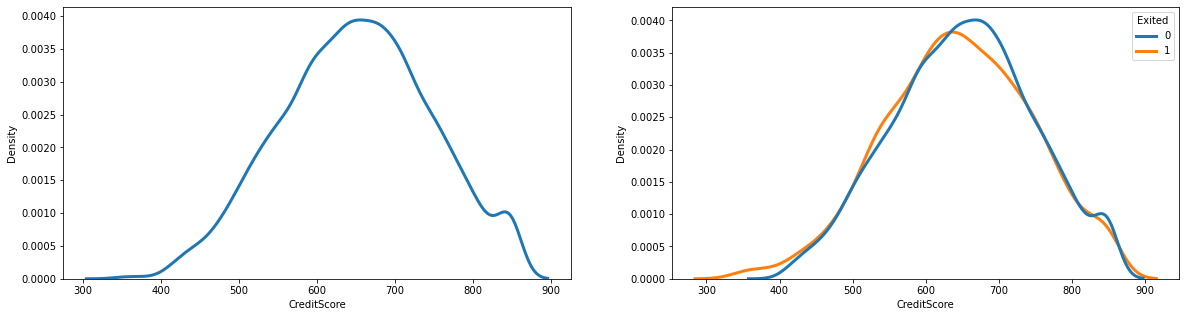

In [3]:
#difference in credit score distributions for two Exited results
fig ,axes = plt.subplots(1,2, figsize=(20,5))
sns.kdeplot(data['CreditScore'], ax=axes[0], linewidth=3)
sns.kdeplot(data['CreditScore'], hue=data['Exited'], ax=axes[1], linewidth=3,common_norm=False)

<AxesSubplot:xlabel='Balance', ylabel='Density'>

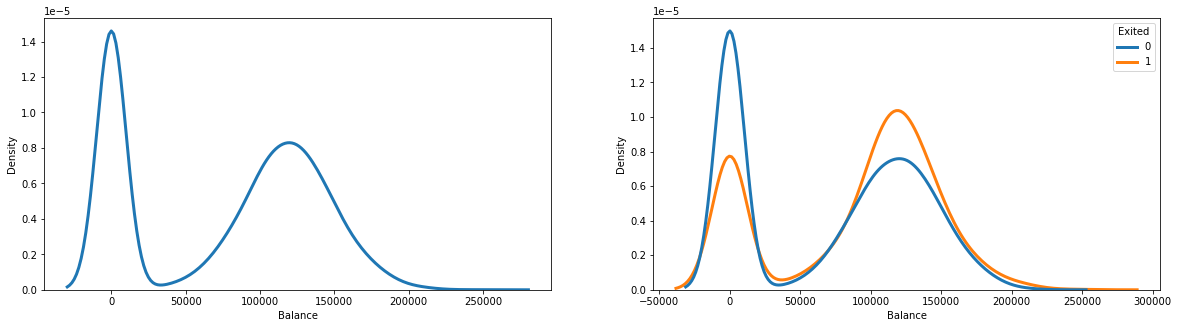

In [4]:
#difference in balance ditributions for two Exited results
fig ,axes = plt.subplots(1,2, figsize=(20,5))
sns.kdeplot(data['Balance'], ax=axes[0], linewidth=3)
sns.kdeplot(data['Balance'], hue=data['Exited'], ax=axes[1], linewidth=3,common_norm=False)

<AxesSubplot:xlabel='Age', ylabel='Density'>

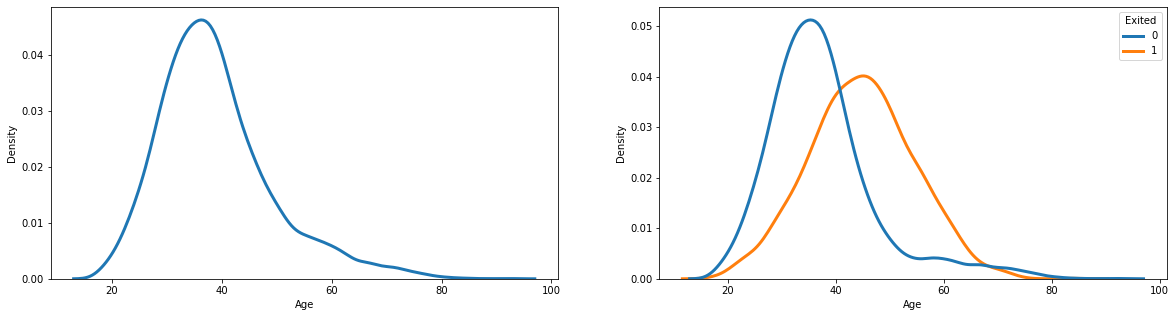

In [5]:
#Difference in Age ditributions for two Exited results
fig ,axes = plt.subplots(1,2, figsize=(20,5))
sns.kdeplot(data['Age'], ax=axes[0], linewidth=3)
sns.kdeplot(data['Age'], hue=data['Exited'], ax=axes[1], linewidth=3,common_norm=False)

<AxesSubplot:xlabel='Age', ylabel='Balance'>

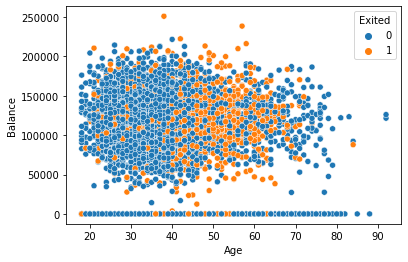

In [6]:
#Find that Exited result affects most on Age and Balance distribution, so make a scatterplot
sns.scatterplot(x=data["Age"],y=data["Balance"],hue=data["Exited"])

### Second, Check the factors features: hasCreditCr, NumOfProducts...

<AxesSubplot:xlabel='NumOfProducts', ylabel='Density'>

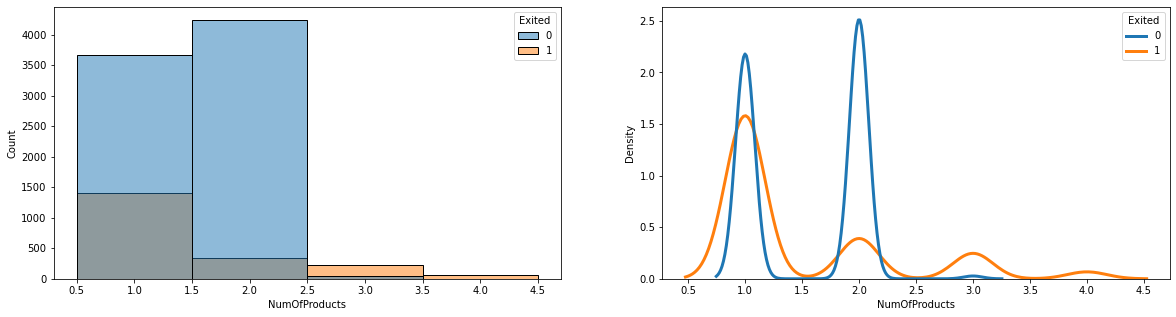

In [7]:
#number of products
fig ,axes = plt.subplots(1,2, figsize=(20,5))
sns.histplot(x=data["NumOfProducts"],hue=data["Exited"],bins=1,common_bins=True,binwidth=0.25,ax=axes[0],discrete=True)
sns.kdeplot(data["NumOfProducts"], hue=data['Exited'], ax=axes[1], linewidth=3,common_norm=False)
#Notice that the proportion of churned customers doesn't follow a homogeneous relationship with the number of products, so it should be dummified into 3 2 level factors

<AxesSubplot:xlabel='Tenure', ylabel='Count'>

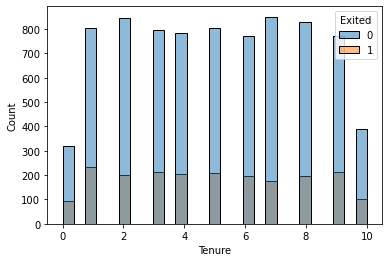

In [8]:
#Tenure
sns.histplot(x=data["Tenure"],hue=data["Exited"],common_bins=True,cumulative=False)
#no peculier pattern

<AxesSubplot:xlabel='Geography', ylabel='Count'>

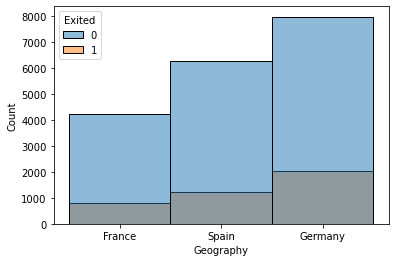

In [9]:
#nationality
sns.histplot(x=data["Geography"],hue=data["Exited"],common_bins=True,binwidth=0.25,cumulative=True)

<AxesSubplot:xlabel='Gender', ylabel='Probability'>

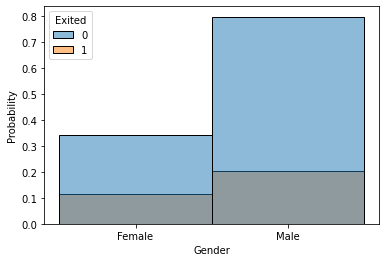

In [10]:
#Gender
sns.histplot(x=data["Gender"],hue=data["Exited"],common_bins=True,binwidth=0.25,cumulative=True,stat="probability")

## Data manipulation
### filtering out the 3 unused  features

In [11]:
#filering out the unuseful features (specifically, the rownumber, ID, and surname), don't run this for multiple times
data = data.iloc[:,3:14]
data.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


#dummifying factor variables (e.g. NumOfProducts, Geography and Gender)

In [12]:
bank = data.copy()
bank['France'] = bank['Geography'].apply(lambda x:1 if x=='France' else 0)
bank['Spain'] = bank['Geography'].apply(lambda x:1 if x=='Spain' else 0)
bank['Gender_F'] = bank['Gender'].apply(lambda x:1 if x=='Female' else 0)
bank['productIs1'] = bank['NumOfProducts'].apply(lambda x:1 if x==1 else 0)
bank['productIs2'] = bank['NumOfProducts'].apply(lambda x:1 if x==2 else 0)
bank['productIs3'] = bank['NumOfProducts'].apply(lambda x:1 if x==3 else 0)
#now drop the old Gender and Geography features because dummy variables replaces
bank.drop(['Gender','Geography','NumOfProducts'], inplace=True, axis=1)
bank.head(10)

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Spain,Gender_F,productIs1,productIs2,productIs3
0,619,42,2,0.00,1,1,101348.88,1,1,0,1,1,0,0
1,608,41,1,83807.86,0,1,112542.58,0,0,1,1,1,0,0
2,502,42,8,159660.80,1,0,113931.57,1,1,0,1,0,0,1
3,699,39,1,0.00,0,0,93826.63,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,1,79084.10,0,0,1,1,1,0,0
5,645,44,8,113755.78,1,0,149756.71,1,0,1,0,0,1,0
6,822,50,7,0.00,1,1,10062.80,0,1,0,0,0,1,0
7,376,29,4,115046.74,1,0,119346.88,1,0,0,1,0,0,0
8,501,44,4,142051.07,0,1,74940.50,0,1,0,0,0,1,0
9,684,27,2,134603.88,1,1,71725.73,0,1,0,0,1,0,0


<AxesSubplot:>

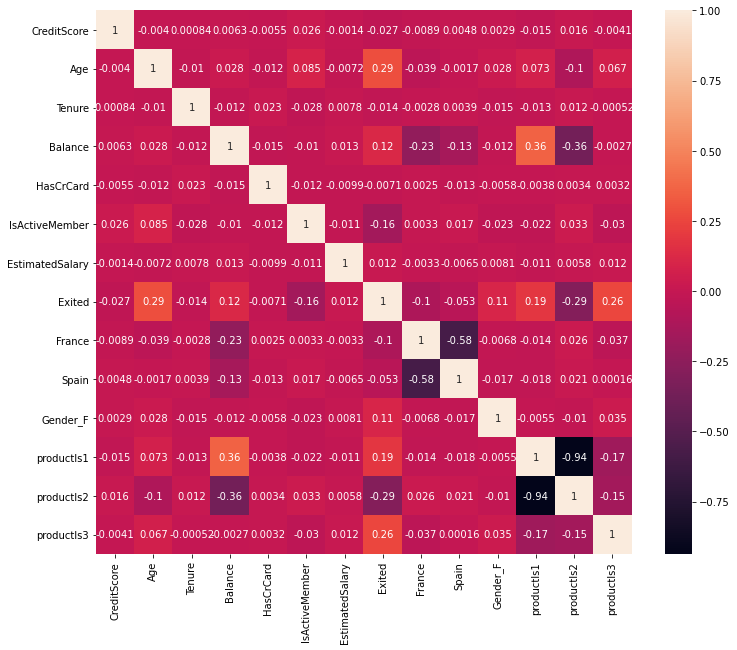

In [13]:
plt.figure(figsize=(12,10))
sns.heatmap(bank.corr(), annot = True)

## CV and model fitting

In [14]:
#before fitting models, preliminary steps are requried:

from sklearn.model_selection import train_test_split
#1. randomly put data into training and test set using train_test_split: y is numpy array and x is pandas dataframe
train, test = train_test_split(bank, test_size=0.2, random_state=42)
y_test = np.array(test['Exited'].tolist())
X_test = test.drop('Exited', axis=1).reset_index(drop=True)
y_train = np.array(train['Exited'].tolist())
X_train = train.drop('Exited', axis=1).reset_index(drop=True)


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
#2. label the factors and normalize X and Y for distance using scaler packages
le = LabelEncoder()
le.fit_transform(y_train)
le.fit_transform(y_test)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#3. Data is imbalanced, so Using SMOTE to sythesize the imbalanced samples making the samples balanced
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote,Y_smote=smote.fit_resample(X_train,y_train)
print(X_train.shape,X_smote.shape,y_train.shape,Y_smote.shape)

#Now we have training data to be X_smote and Y_smote, But model fitting ended up in overfitting results.

(8000, 13) (12712, 13) (8000,) (12712,)


Cost is 1 and gamma is 0.001,having accuracy:
0.813125
Cost is 1 and gamma is 0.01,having accuracy:
0.837
Cost is 1 and gamma is 0.1,having accuracy:
0.8545000000000001
Cost is 1 and gamma is 0.5,having accuracy:
0.8327499999999999
Cost is 1 and gamma is 1,having accuracy:
0.811875
Cost is 1 and gamma is 3,having accuracy:
0.7954999999999999
Cost is 1 and gamma is 5,having accuracy:
0.794875
Cost is 3 and gamma is 0.001,having accuracy:
0.813125
Cost is 3 and gamma is 0.01,having accuracy:
0.8525
Cost is 3 and gamma is 0.1,having accuracy:
0.8542500000000001
Cost is 3 and gamma is 0.5,having accuracy:
0.82125
Cost is 3 and gamma is 1,having accuracy:
0.796875
Cost is 3 and gamma is 3,having accuracy:
0.793
Cost is 3 and gamma is 5,having accuracy:
0.7955
Cost is 5 and gamma is 0.001,having accuracy:
0.813125
Cost is 5 and gamma is 0.01,having accuracy:
0.8547499999999999
Cost is 5 and gamma is 0.1,having accuracy:
0.85275
Cost is 5 and gamma is 0.5,having accuracy:
0.810125
Cost is 5 a

<AxesSubplot:>

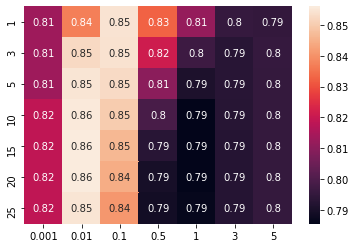

In [60]:
# First CV on SVM
from sklearn import svm
from sklearn.model_selection import cross_val_score
CV = 10
CList = [1,3,5,10,15,20,25]
GList = [0.001,0.01,0.1,0.5,1,3,5]
ParameterAccuracy_array = []
for Cs in CList:
    for Gs in GList:
        svmModel = svm.SVC(kernel='rbf', C=Cs, gamma= Gs)
        scores = cross_val_score(svmModel, X_train, y_train, cv=CV)
        print("Cost is {} and gamma is {},having accuracy:".format(Cs, Gs))
        ParameterAccuracy_array.append(sum(scores)/CV)
        print(ParameterAccuracy_array[len(ParameterAccuracy_array)-1])
        
ParameterAccuracy_array = np.array(ParameterAccuracy_array)

ParameterAccuracy_matrix = np.matrix(ParameterAccuracy_array.reshape(len(CList),len(GList)))

print(ParameterAccuracy_array)

sns.heatmap(ParameterAccuracy_matrix, annot = True, xticklabels = GList, 
            yticklabels = CList)


In [16]:
#Therefore, the best parameter is C=5, gamma=1.5 for SVM
from sklearn.metrics import accuracy_score,classification_report,f1_score
bestSVM = svm.SVC(kernel='rbf', C=10, gamma= 0.01)
bestSVM.fit(X_train, y_train)
#Predict with this set:
y_pred = bestSVM.predict(X_test)
print("test score:")
print(accuracy_score(y_test,y_pred))

accuracy:
0.8585


Depth is 3,having accuracy:
0.8183750000000002
Depth is 10,having accuracy:
0.85
Depth is 30,having accuracy:
0.85925
Depth is 50,having accuracy:
0.85775
Depth is 100,having accuracy:
0.8590000000000002
Depth is 150,having accuracy:
0.8606250000000001
Depth is 200,having accuracy:
0.8589999999999998
Depth is 250,having accuracy:
0.8602500000000001
Depth is 300,having accuracy:
0.860625
Depth is 400,having accuracy:
0.86075
Depth is 500,having accuracy:
0.8618750000000001


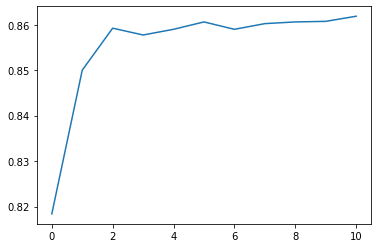

In [36]:
#Then Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
depth = [3,10,30,50,100,150,200,250,300,400,500]
CV=10
depthAccuracy_array = []
for N in depth:
    rfModel=RandomForestClassifier(N)
    scores = cross_val_score(rfModel, X_train, y_train, cv=CV)
    print("Depth is {},having accuracy:".format(N))
    depthAccuracy_array.append(sum(scores)/CV)
    print(depthAccuracy_array[len(depthAccuracy_array)-1])
    
plt.plot(depth,depthAccuracy_array) 
# Add Title

plt.title("RandomForest CV VS. Depth") 

# Add Axes Labels

plt.xlabel("Depth of Random Forest") 
plt.ylabel("CV Accuracy") 
plt.show()

In [19]:
#CV accuracy peaks at depth = 200
BestRF=RandomForestClassifier(200)
BestRF.fit(X_train,y_train)
y_pred_RF=BestRF.predict(X_test)
accuracy_score(y_test,y_pred_RF)

0.868

__________________________________________________________
For Model:  Random Forest
__________________________________________________________


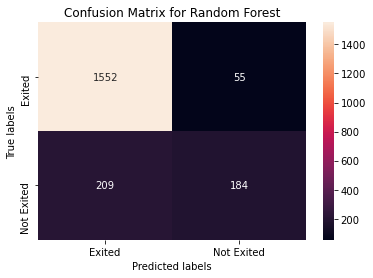

Accuracy :  0.868
Sensitivity :  0.8813174332765474
Specificity :  0.7698744769874477
__________________________________________________________
For Model:  SVM with Radial Kernel
__________________________________________________________


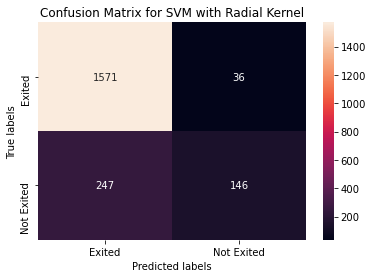

Accuracy :  0.8585
Sensitivity :  0.8641364136413642
Specificity :  0.8021978021978022



In [46]:
def printResult (y_test,y_pred,name="Not specified"):
    print("__________________________________________________________")
    print("For Model: ", name)
    print("__________________________________________________________")
    from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, fbeta_score, classification_report, mean_squared_error
    cm = confusion_matrix(y_test, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title("Confusion Matrix for {}".format(name)); 
    ax.xaxis.set_ticklabels(['Exited', 'Not Exited']); ax.yaxis.set_ticklabels(['Exited', 'Not Exited']);
    
    plt.show()
    
    
    total=sum(sum(cm))
    accuracy=(cm[0,0]+cm[1,1])/total
    print ('Accuracy : ', accuracy)

    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    print('Sensitivity : ', sensitivity )

    specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    print('Specificity : ', specificity)
    

printResult(y_test,y_pred_RF,"Random Forest")

printResult(y_test,y_pred,"SVM with Radial Kernel")

print()
    

